# Pronóstico adaptativo

## Descripción del problema real

Los pronósticos de los precios de la electricidad en mercados liberalizados son un insumo fundamental para la toma de decisiones dentro de las organizaciones. Fundamentalmente, los pronosticos de corto plazo son utilizados en decisiones de carácter operativo. En el caso abordado, es necesario contar con los pronósticos para definir la politica de operación de una empresa del sector eléctrico.

## Descripción del problema en términos de los datos

La carpeta `datos/precios/` contiene los precios historicos horarios de la electricidad en la Bolsa de Energía del mercado eléctrico colombiano, publicados por el operador del mercado. Se desean obtener pronósticos para el precio promedio diario para los próximos siete (7) días a la fecha actual.

## Aproximaciones posibles

En este caso, se desea evaluar la capacidad de pronóstico de un ADALINE con aprendizaje en línea.

## Requerimientos

Usted debe:

* Procesar los datos históricos para conformar el conjunto de datos. Los archivos de Excel no pueden ser modificados y actualizados directamente por el operador del sistema. Su código debe leer los archivos y crear la serie de precios promedio diarios de la electricidad.


* Determinar si el modelo debe pronosticar los precios promedios sin ninguna transformación, o si la inclusión de una transformación (logaritmo natural, raíz cúbica, raíz cuadrada, etc) resulta en un incremento de la precisión del pronóstico.


* Generar el pronóstico para los precios de los próximos siete días.


* Preparar el código para que el modelo sea entrenado usando el gradiente y el momentum.


* Determinar cuál es el número óptimo de retardos (observaciones) que el modelo debe considerar hacia atrás para producir el pronóstico.


* Determinar los valores óptimos de la tasa de aprendizaje y el momentum.


# Desarrollo del ejercicio

In [1]:
##Importar las librerias necesarias para trabajar 
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.neural_network import MLPRegressor
from datetime import datetime

%matplotlib inline

## Lectura de datos
En primer lugar se leen los datos provenientes de los archivo de Excel facilitados por el profesor. Para esto se hace uso de la libreria pandas (pd) y sus funciones. Tambien, se utiliza la libreria os (uno de los modulos del sistema de phython) para manejo del directorio de archivos

In [2]:
#Extraer los datos de precios de la electricidad

##Este es la direccion donde estan todos los Exceles de donde saldran los datos
ruta  = r'C:\Users\nelson.barco\NFBB\Redes Neuronales\evaluacion-nfbarcob03-master\evaluacion-nfbarcob03-master\datos\precios'

##Guardamos en un arreglo el nombre de todos los archivos que estan en el directorio al que apunta el path para 
##extraer su contenido
archivos = os.listdir(ruta)

##Hacemos un arreglo con el nombre para las columnas del dataframe donde se almacenaran los datos de los archivos excel
columnas = ['Fecha', "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14","15", "16", "17", "18", 
            "19", "20", "21", "22", "23"]

##Creamos el data frame donde almacenaremos los datos de los precios para todos los años, con las columnas definidas
data = pd.DataFrame(columns=columnas)

##El siguiente ciclo se encarga de recorrer la lista con los nombres de los archivos Excel
for archivo in archivos:
    if "Precio" in archivo:
        ##Leemos el siguiente archivo Excel, el cual estara en la direccion ruta+nombre_archivo y lo guardamos en un 
        ##data frame temporal con el cual trabajaremos
        ##Tomamos las columnas de la 0 (donde estan las fechas) a la 25 (son 24 horas del dia, en cada hora se reporta el precio)
        dataFrame = pd.read_excel(ruta+"\\"+archivo, usecols=list(range(0, 25)))
        
        ##Setiamos las columnas del data frame temporal para que concuerden con el data frame donde estara la data total
        dataFrame.columns = columnas
        
        ##Se borran las filas que contengan mas de 3 valores no definidos (NaN), esto para asegurar no borrar filas con datos
        #y solo borrar las filas que no pertenecen al grueso de la data
        dataFrame = dataFrame.dropna(thresh=4)   

        ##Se borra la primera fila del dataframe por que tiene el nombre de las columnas
        dataFrame = dataFrame.drop(dataFrame.index[0])
        
        ##Como se han borrado varias filas se resetean los indices de estas
        dataFrame.reset_index(drop=True, inplace=True)

        ##juntamos el data frame temporal con el data frame de la data total
        data = pd.concat([data, dataFrame])
        
print("El dataframe que almacena la data total tiene ", data.shape[0], " filas y ", data.shape[1], " columnas.")

#Imprimir las primeras filas del data frame
data.head(5)

El dataframe que almacena la data total tiene  8400  filas y  25  columnas.


,Fecha,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,1995-07-20,NaN,1.073,1.073,1.073,1.073,1.073,1.073,1.073,1.074,...,1.073,1.073,1.073,1.073,1.074,1.897,1.897,1.897,1.073,1.073
1,1995-07-21,1.073,1.000,1.000,1.000,1.000,1.000,5.000,6.000,6.000,...,5.000,1.000,1.000,5.000,12.000,16.670,11.929,5.000,1.000,1.000
2,1995-07-22,1.073,1.073,1.000,1.000,1.000,1.073,1.303,1.303,1.303,...,1.073,1.000,1.000,1.000,1.303,2.500,2.500,1.303,1.073,1.073
3,1995-07-23,1.073,1.000,1.000,1.000,1.000,1.000,0.100,1.000,1.000,...,1.000,0.100,0.100,1.000,1.238,1.238,1.238,1.238,1.073,1.000
4,1995-07-24,1,1.000,0.990,1.000,1.000,1.073,3.000,3.000,3.000,...,1.073,1.073,3.000,2.000,18.630,22.500,9.256,3.000,1.073,1.000


## Preprocesamiento de datos

En la data proveniente de los archivos Excel facilitados por el profesor se encuentran precios para la electricidad (en $/kWh) para todos los dias desde 1995 hasta 2018. La data esta conformada por precios tomados hora a hora durante las 24 horas del dia. 

Los modelos de predicción que se desarrollaran haran predicciones de los precios para la electricidad diarios, por tanto, para alimentar estos modelos es necesario en primer lugar tener un precio promedio para cada uno de los dias (desde el 1995 al 2018) y luego normalizar estos llevandolos a la misma linea base, quitando el cesgo de la inflación. Para llevar acabo lo anterior se hara uso del IPC historico, el cual se obtuvo de la pagina del Banco de la Republica

### Promedio precios diarios historicos

En primer lugar se tomaron los datos de cada dia y se sacaron los promedios con funciones de la libreria pandas

In [3]:
#Primero se sacan las columnas de los precios para todos los dias del dataframe total, excluyendo la columna de la fecha
#y se almacena en un data frame dodne estaran los promedios de los precios para cada dia
dataPromedio = data.iloc[:,1:25]

#Se saca el promedio con la funcion mean() de pandas para cada una de las filas, es decir, para cada uno de los dias
#y se almacena en una columna nueva en el nuevo dataframe
dataPromedio['precioPromedioDia'] = dataPromedio.mean(axis=1)

#Se adiciona la columna de la fecha del dataframe total al dataframe donde se almacenan los promedios
dataPromedio['Fecha']=data.iloc[:,0]

#Finalmente, solo se dejan las columnas de fecha y precio promedio en el data frame, excluyendo las demas columnas (precios por hora)
dataPromedio = pd.DataFrame(dataPromedio, columns=['Fecha','precioPromedioDia'])

##Se borran filas con datos Nan para limpiar la data con la que se trabajara
dataPromedio = dataPromedio.dropna() 

#Se eliminan los duplicados 
dataPromedio.drop_duplicates(subset="Fecha", inplace=True)

print("El dataframe que almacena los precios promedio por dia tiene ", dataPromedio.shape[0], " filas y ", 
      dataPromedio.shape[1], " columnas.")

#Imprimir las primeras filas del data frame
dataPromedio.head(5)


El dataframe que almacena los precios promedio por dia tiene  8326  filas y  2  columnas.


,Fecha,precioPromedioDia
0,1995-07-20,1.409435
1,1995-07-21,4.924333
2,1995-07-22,1.269500
3,1995-07-23,0.953083
4,1995-07-24,4.305917


Se procede a graficar el precio promedio por dia de la energia (sin aplicar el  IPC) Vs la fecha, para esto se hace una depuraciòn de los datos, eliminando los repetidos

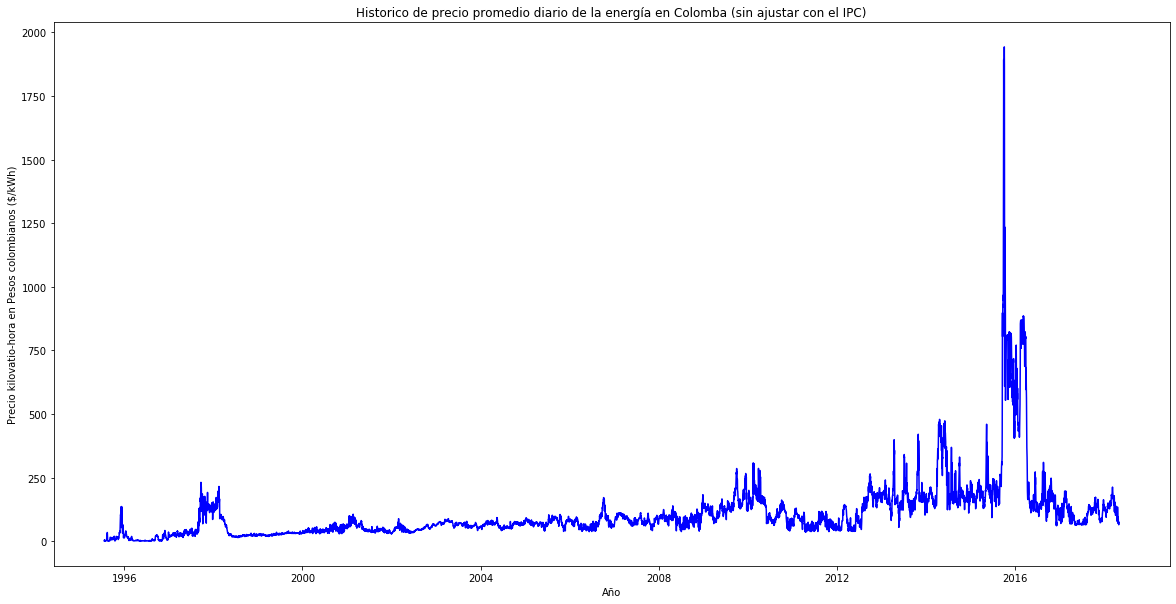

In [4]:
##Configuramos el objeto plot que se utilizara para generar el grafico
plt.figure(figsize=(20,10))

# La columna donde esta la fecha es de tipo Series, se lleva al tipo date para poder graficarlo
#dataPromedio['Fecha']=pd.to_datetime(dataPromedio['Fecha'])
dataPromedio['Fecha']=pd.to_datetime(dataPromedio['Fecha'])

# Se ordenan los datos por fecha de forma descendente
dataPromedio.sort_values(by='Fecha')

#Se configura el objeto plot con sus atributos (titulo principal, titulo de los ejes y caracteristicas de la grafica)
plt.title('Historico de precio promedio diario de la energía en Colomba (sin ajustar con el IPC)')
plt.xlabel('Año')
plt.ylabel('Precio kilovatio-hora en Pesos colombianos ($/kWh)')
plt.plot(dataPromedio['Fecha'], dataPromedio['precioPromedioDia'], color='blue')

#Se muestra el grafico
plt.show()

 

Se procede a extraer el IPC para cada fecha y almacenarlo en un dataframe. El archivo de Excel se encuentra en la misma direccion que los archivos de los precios. Este fue obtenido de la pagina del [Banco de la Republica](https://www.banrep.gov.co/es). [Link Descarga documento historico IPC](https://totoro.banrep.gov.co/analytics/saw.dll?Download&Format=excel2007&Extension=.xls&BypassCache=true&lang=es&NQUser=publico&NQPassword=publico123&path=%2Fshared%2FSeries%20Estad%C3%ADsticas_T%2F1.%20IPC%20base%202018%2F1.2.%20Por%20a%C3%B1o%2F1.2.5.IPC_Serie_variaciones)

In [5]:
#Se leen los datos del hisotorico del IPC, se excluyen las primeras 12 filas que son del encabezado y las ultimas 6 del pie
#de pagina y sin conservar valores Nan
dataIPC = pd.read_excel(ruta + '\\1.2.5.IPC_Serie_variaciones.xlsx',header=12, skipfooter=6, keep_default_na=False)

#Se setean las columnas del dataframe
dataIPC.columns = ['FechaIPC', 'IPC', "inflacionAnual","inflacionMensual", "inflacionAñoCorrido" ]

#Se aplica una funcion la,bda para modificar todas las filas en la columna Fecha, para darles formato. 
#Lo anterior es más sencillo si son strings
dataIPC['FechaIPC'] =dataIPC['FechaIPC'].apply(lambda x: datetime.strptime(str(x),"%Y%m"))

#Se lleva a tipo date la columna de Fecha
dataIPC['FechaIPC'] = pd.to_datetime(dataIPC['FechaIPC']).dt.to_period('M')

#En el dataframe donde se tiene el promedio diario de los precios se crea una nueva columna con el mismo formato de la columna
#que tiene la fecha en el dataframe del IPC para poder hacer el merge
dataPromedio['FechaIPC'] = pd.to_datetime(dataPromedio['Fecha']).dt.to_period('M')


print("El tamaño de la data del IPC es de ", dataIPC.shape[0], " filas (fechas) y ", dataIPC.shape[1], " columnas")

#Imprimir las primeras filas del data frame
dataIPC.head(5)

El tamaño de la data del IPC es de  788  filas (fechas) y  5  columnas


,FechaIPC,IPC,inflacionAnual,inflacionMensual,inflacionAñoCorrido
0,1954-07,0.03,,,
1,1954-08,0.03,,-0.76,-0.76
2,1954-09,0.03,,-1.37,-2.12
3,1954-10,0.03,,0.34,-1.79
4,1954-11,0.03,,0.27,-1.52


se utiliza la funcion merge de pandas para unir los dos data frames (el que tiene los precios diarios promedios y el que tiene el IPC) por medio de un campo que tengan en comun (FechaIPC). Lo anterior es necesario, ya que los precios estan por dias y los IPC por meses

In [7]:
##Se hace el merge de los dos dataframe en base al campo en comun FechaIPC
dataTotal = pd.merge(dataPromedio, dataIPC, on="FechaIPC", how="left")

#Imprimir las primeras filas del data frame
dataTotal.head(20)

,Fecha,precioPromedioDia,FechaIPC,IPC,inflacionAnual,inflacionMensual,inflacionAñoCorrido
0,1995-07-20,1.409435,1995-07,20.93,21.5,0.77,14.7
1,1995-07-21,4.924333,1995-07,20.93,21.5,0.77,14.7
2,1995-07-22,1.269500,1995-07,20.93,21.5,0.77,14.7
3,1995-07-23,0.953083,1995-07,20.93,21.5,0.77,14.7
4,1995-07-24,4.305917,1995-07,20.93,21.5,0.77,14.7
5,1995-07-25,1.149167,1995-07,20.93,21.5,0.77,14.7
6,1995-07-26,1.108625,1995-07,20.93,21.5,0.77,14.7
7,1995-07-27,0.585958,1995-07,20.93,21.5,0.77,14.7
8,1995-07-28,0.499792,1995-07,20.93,21.5,0.77,14.7
9,1995-07-29,0.927667,1995-07,20.93,21.5,0.77,14.7


Ahora se calcula el precio promedio deflactado, al inicio, para cada uno de los dias del dataframe. Se debe tener como base un IPC en especifico correspondiente a la fecha de referencia a la que se van a llevar todos los precios para quitar el cesgo de la inflación. En este caso sera el primer dato del dataframe (1995-07-20). 

Para lo anterior se hara uso de la siguiente ecuación:

$$PrecioDeflactado = PrecioActual* \frac{IPCBase}{IPCActual}$$

$Donde:$

$PrecioDeflactado: Variable que se busca, es el precio llevado a la fecha de referencia$

$PrecioActual: Es el precio que se desea deflactar$

$IPCBase: Es el IPC a la fecha de referencia$

$IPCActual: es el IPC a la fecha del precio que se desea deflactar$



In [11]:
IPCBase=dataTotal['IPC'][0]
print(IPCBase)
dataTotal['precioPromedioDiaNormalizado'] = dataTotal['precioPromedioDia']*(IPCBase/dataTotal['IPC'])

#Imprimir las primeras filas del data frame
dataTotal.head(-20)

20.93


,Fecha,precioPromedioDia,FechaIPC,IPC,inflacionAnual,inflacionMensual,inflacionAñoCorrido,precioPromedioDiaNormalizado
0,1995-07-20,1.409435,1995-07,20.93,21.5,0.77,14.7,1.409435
1,1995-07-21,4.924333,1995-07,20.93,21.5,0.77,14.7,4.924333
2,1995-07-22,1.269500,1995-07,20.93,21.5,0.77,14.7,1.269500
3,1995-07-23,0.953083,1995-07,20.93,21.5,0.77,14.7,0.953083
4,1995-07-24,4.305917,1995-07,20.93,21.5,0.77,14.7,4.305917
...,...,...,...,...,...,...,...,...
8301,2018-04-11,137.975390,2018-04,98.91,3.13,0.46,2.05,29.196491
8302,2018-04-12,113.736735,2018-04,98.91,3.13,0.46,2.05,24.067434
8303,2018-04-13,120.853637,2018-04,98.91,3.13,0.46,2.05,25.573416
8304,2018-04-14,116.612396,2018-04,98.91,3.13,0.46,2.05,24.675942


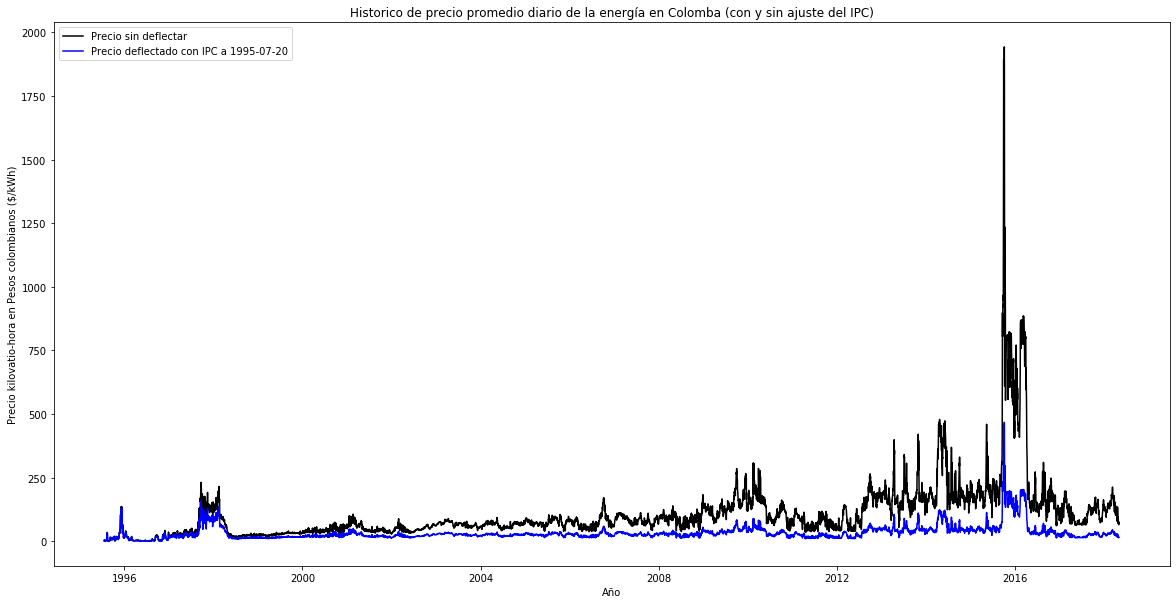

In [14]:
plt.figure(figsize=(20,10))
plt.title('Historico de precio promedio diario de la energía en Colomba (con y sin ajuste del IPC)')
plt.xlabel('Año')
plt.ylabel('Precio kilovatio-hora en Pesos colombianos ($/kWh)')
plt.plot(dataTotal['Fecha'], dataTotal['precioPromedioDia'],label="Precio sin deflectar", color='black')
plt.plot(dataTotal['Fecha'], dataTotal['precioPromedioDiaNormalizado'],label="Precio deflectado con IPC a 1995-07-20", color='blue')
plt.legend()
plt.show()